## Importing Dependencies

In [18]:
## For numerical calculations
import numpy as np
##For plot visualisations
import matplotlib.pyplot as plt
## Tensorflow libraries
import tensorflow as tf
## Model Requirements
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
##Nearest Neighbors , PCA and TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import  TSNE
from sklearn.decomposition import PCA
## For Notebook progress bar and other requirements
from tqdm import tqdm_notebook, tqdm
import pickle
import os
import timeit
import tarfile

### We will consider Caltech101 Dataset which has 101 classes.
### We have tarfile available in the drive and we will unzip it using tarfile library.
### As in the dataset there is one folder apart from 101 folders which has random images and we do not want it to load into our training, so we will delete that folder.

In [2]:
tar_file= tarfile.open('/content/drive/My Drive/Computer Vision Interview/Reverse Image Search/101_ObjectCategories.tar.gz')
tar_file.extractall('/content')
tar_file.close()


In [3]:
## Delete the folder with random images
!rm -rf '/content/101_ObjectCategories/BACKGROUND_Google'

### Model Creation
#### We are using ResNet50 model to create features.
#### There are many ways to create a robust model to extract features. Lets discuss some of them and implement one.
##### Include_top= True:
If we include all the layers and get the features we would get all the features.
##### Include_top=False:
If we exlude the top layer which is of DNN, then we will be having aroung (1,7,7,2048) features. Which would sum up to 1 lakh features which will be difficult to handle as we need to have much more computational power and time.
##### Include_top=False and pooling='max'
The above feature would apply maxpooling to the last layer (1,7,7,2048) which would result in generating features of 2048, which would be very descent and can be acceptable to run in a basic machine.

In [4]:
model= ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='max')

94773248/94765736 [==============================] - 1s 0us/step


In [5]:
### Sumamry of the model
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Now we have the model and we need to collect the data.
#### Data is present in the drive. Now we will pull the data and store all the filenames in the list.

In [6]:
### Collect all the extensions
root_dir='/content/101_ObjectCategories'
extensions=['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']
file_list=[]
## Consider all the files take the directories and root and file names
for root, directories, filenames in os.walk(root_dir):
  ### Loop around filenames and append the root path to get the total path of the file
  for filename in filenames:
    ##Check if the filename consists of image extensions then append
    if any([ext in filename for ext in extensions]):
      file_list.append(os.path.join(root, filename))


### now lets view a sample image

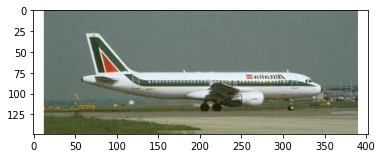

In [9]:
sample_path= file_list[4345]
sample_image= plt.imread(sample_path)
plt.imshow(sample_image)

### Now we have got the model and dataset.
#### Before sending the data to prediction, we have to preprocess the data and after prediction post processing has to be done.

In [13]:
def extract_features(image_path, model):
  input_shape=(224,224)
  ### load the image
  input_image= image.load_img(image_path, target_size=input_shape)
  ##convert image to array
  input_image= img_to_array(input_image)
  ###Expand the image so that it fits like batch
  input_image= np.expand_dims(input_image, axis=0)
  ## PreProcess the image
  input_image= preprocess_input(input_image)
  ###Predict the image
  predict_image= model.predict(input_image)
  ##flatten the features
  feature= predict_image.flatten()
  ###Normalise the feature
  normalize_feature= feature/ np.linalg.norm(feature)

  return normalize_feature

### We are all set for the extraction of features
#### We will loop for each file and predict the image and store the features in a list

In [15]:
feature_list=[]
for filename in tqdm_notebook(file_list):
  feature_list.append(extract_features(filename, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Now we have got the  featurelist and file list of all the images
#### For future purposes we will save it in drive in the form of pickle file.

In [16]:
pickle.dump(feature_list, 
            open('/content/drive/My Drive/Computer Vision Interview/Reverse Image Search/feature weights/feature_list.pickle', 
                 'wb'))
pickle.dump(file_list, open('/content/drive/My Drive/Computer Vision Interview/Reverse Image Search/feature weights/file_list.pickle', 
                 'wb'))

In [17]:
feature_list[23].shape

(2048,)

### We got the features, now lets pass these features to nearest neighbors and train.
### After training we will predict the likely images

In [21]:
neighbors= NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')
neighbor_result= neighbors.fit(feature_list)

In [22]:
### lets Predict the likely images
distance, index= neighbor_result.kneighbors([feature_list[4568]])

In [23]:
### Lets view the values of distance and 
##distance: distance between the input and the resulted images
##index: index of the files in the file_list
distance, index

(array([[4.4703484e-08, 5.4479134e-01, 5.5386841e-01, 5.5389661e-01,
         5.5509919e-01]], dtype=float32),
 array([[4568, 4137, 4690, 4653, 4538]]))

### Now we have got the index and distances
### Lets plot the images in  a single image using matplotlib

In [28]:
def plot_neighbors(file_list, index):
  ##Create a figure
  fig= plt.figure(figsize=(15,15))
  ##loop over index and draw images
  for i, idx in enumerate(index):
    ##Create subplot
    ax= plt.subplot(1, len(index), i+1)
    ##Plot the image
    image= plt.imread(file_list[idx])
    plt.imshow(image)


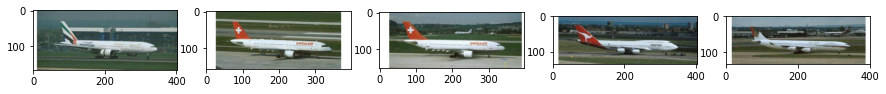

In [29]:
### Lets plot the results
plot_neighbors(file_list, index[0])

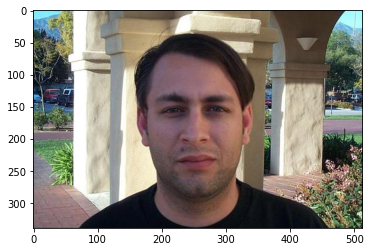

In [48]:
### This seems looking right.
##Lets try with another sample image
sample_path= file_list[7990]
sample_image= plt.imread(sample_path)
plt.imshow(sample_image)

In [49]:
### Lets find out NN and plot the results
distance, index= neighbor_result.kneighbors([feature_list[7990]])

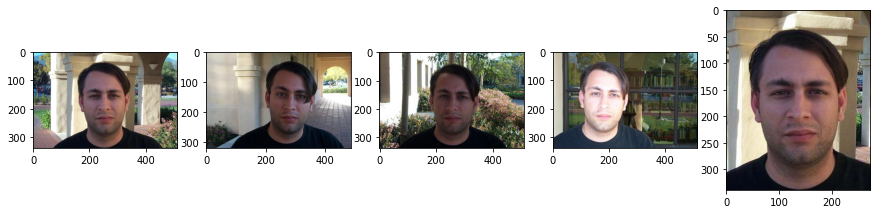

In [50]:
## plot the result
plot_neighbors(file_list, index[0])

### This seems pretty good.
### Now lets check some un-usual cases


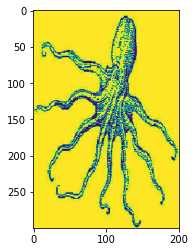

In [51]:
sample_path= file_list[856]
sample_image= plt.imread(sample_path)
plt.imshow(sample_image)

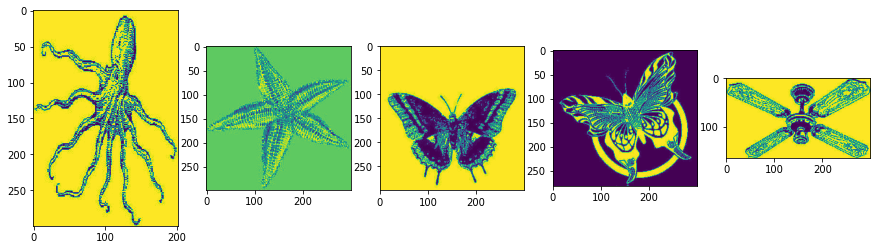

In [53]:
### Lets check the NN
distance, index= neighbor_result.kneighbors([feature_list[856]])
plot_neighbors(file_list, index[0])

### Here if you can see the result is showing different results.
### We can able to finetune using PCA which reduces the dimensions of the features.
#### 100 would be the ideal dimensions where we can get the best results.

In [55]:
pca=PCA(n_components=100)
pca_transform=pca.fit_transform(feature_list)

After transformation the earlier 2048 dimensions have been reduced to 100 dimensions. Let us check the accuracy

In [58]:
## Now lets pass the Pca result to NN for training
pca_neighbors= neighbors.fit(pca_transform)

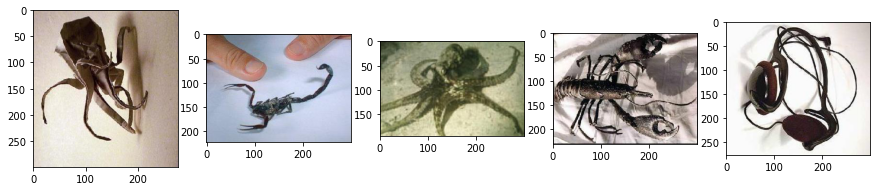

In [61]:
distance, index= pca_neighbors.kneighbors([pca_transform[859]])
plot_neighbors(file_list, index[0])

### As you can see in the above list of likely images where compared to the earlier ones we could able to get some finetuned images.
#### Hint: We can get much more accurated images by finetuning the layers of the model where we can add DNN to the layers

## Plotting our accuracy
### We use T-stochastic Neighbor embedding (T-SNE) to plot the high dimensional data to human understandable on a 2-D

In [62]:
tsne= TSNE(n_components=2, perplexity=30.0, n_iter=1000, metric='euclidean', verbose=1)

#### Considering T-SNE for all the classes would be time taking and little clumpsy in the chart.
#### Lets take for few images in the dataset and plot

In [67]:
### Lets plot for normal feature list(with out PCA)
tsne_file_list= file_list[2500:4500]
tsne_feature_list= feature_list[2500:4500]
tsne_results= tsne.fit_transform(tsne_feature_list)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.433s...
[t-SNE] Computed neighbors for 2000 samples in 18.334s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.215512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.552101
[t-SNE] KL divergence after 1000 iterations: 0.735059


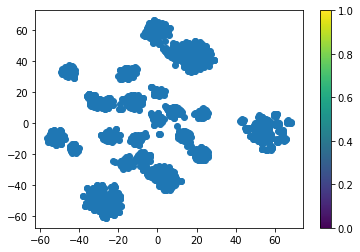

In [70]:
### now lets plot the T-SNE with colormap
colormap= plt.cm.get_cmap('coolwarm')
scatter=plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap=colormap)
plt.colorbar(scatter)
plt.show()

### Now we will check the same for pca features

In [71]:
tsne_pca_feature_list= pca_transform[2500:4500]
tsne_results= tsne.fit_transform(tsne_pca_feature_list)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.020s...
[t-SNE] Computed neighbors for 2000 samples in 0.840s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.172699
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.977917
[t-SNE] KL divergence after 1000 iterations: 0.708202


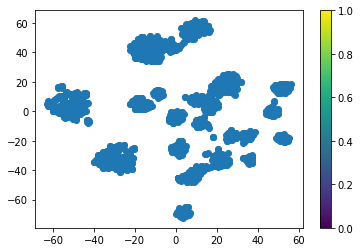

In [72]:
### now lets plot the T-SNE with colormap
colormap= plt.cm.get_cmap('coolwarm')
scatter=plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap=colormap)
plt.colorbar(scatter)
plt.show()

The result would be much more clearer, if we add colors to the plot.